Папка на GDrive:

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing


In [1]:
from os import listdir

USE_GDRIVE = False


if USE_GDRIVE:
    from google.colab import drive
    drive.mount("/home/GDrive")
    DATA_PATH = f"/home/GDrive/MyDrive/made_2021_fraud_project/data"
else:
    DATA_PATH = "../../data"

GPS_PATH = "../../data/gps_data.csv"
ACCEL_PATH = "../../data/accel_data.csv"

listdir(DATA_PATH)

['drivers_stats.csv',
 'gps_data.csv',
 'unlabeled',
 'good_data',
 'points_stats.csv',
 'all_gps.csv',
 'all_accel.csv',
 'accel_data.csv',
 'drivers_with_gps_and_sl_problems',
 'gps_stats.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv']

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import folium
from haversine import haversine
from tqdm import tqdm

%matplotlib inline

In [3]:
def describe(df):
    display(pd.concat((df.dtypes, df.describe(datetime_is_numeric=True).T), axis=1))
    display(df.shape)

In [4]:
df_gps = pd.read_csv(GPS_PATH, parse_dates=[0, 3])
describe(df_gps)

,0,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2021-04-06 10:23:00.788006400,2020-10-25 03:59:58,2021-01-16 06:40:41.750000128,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2021-04-06 10:22:58.275877632,2020-10-25 03:59:56,2021-01-16 06:40:38.749999872,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076


(5050292, 6)

In [5]:
df_diff = df_gps - df_gps.shift()
describe(df_diff)

,0,count,mean,std,min,25%,50%,75%,max
time,timedelta64[ns],5050291,-1 days +23:59:58.859008917,1 days 00:10:33.376107873,-290 days +06:02:33,0 days 00:00:02,0 days 00:00:03,0 days 00:00:03,291 days 23:30:47
lat,float64,5.05029e+06,3.35806e-08,0.0193518,-26.5774,-1.9e-05,0,1.7e-05,26.5843
lon,float64,5.05029e+06,-3.76345e-08,0.0970157,-97.5547,-2.9e-05,0,3.1e-05,97.5547
gps_time,timedelta64[ns],5050291,-1 days +23:59:58.859008917,1 days 00:10:34.182964582,-290 days +06:02:33,0 days 00:00:02,0 days 00:00:03,0 days 00:00:03,291 days 23:30:50
driver_hash,float64,5.05029e+06,-8.04058e+11,6.25766e+16,-1.81275e+19,0,0,0,1.75955e+19
fraud,float64,5.05029e+06,-3.96017e-07,0.000629299,-1,0,0,0,0


(5050292, 6)

In [6]:
df_diff.loc[0,:] = df_diff.min()
df_diff["time"] = np.clip(df_diff["time"], pd.Timedelta("-1d"), pd.Timedelta("1d"))
df_diff["gps_time"] = np.clip(df_diff["gps_time"], pd.Timedelta("-1d"), pd.Timedelta("1d"))
df_diff["lat"] = np.clip(df_diff["lat"], -1.0, 1.0)
df_diff["lon"] = np.clip(df_diff["lon"], -1.0, 1.0)
df_diff["driver_hash"] = df_gps["driver_hash"]
df_diff["fraud"] = df_gps["fraud"]

describe(df_diff)

,0,count,mean,std,min,25%,50%,75%,max
time,timedelta64[ns],5050292,0 days 00:00:08.695668884,0 days 00:12:36.881036139,-1 days +00:00:00,0 days 00:00:02,0 days 00:00:03,0 days 00:00:03,1 days 00:00:00
lat,float64,5.05029e+06,-3.61725e-07,0.00267579,-1,-1.9e-05,0,1.7e-05,1
lon,float64,5.05029e+06,2.45236e-07,0.00365716,-1,-2.9e-05,0,3.1e-05,1
gps_time,timedelta64[ns],5050292,0 days 00:00:08.675599945,0 days 00:12:33.247601388,-1 days +00:00:00,0 days 00:00:02,0 days 00:00:03,0 days 00:00:03,1 days 00:00:00
driver_hash,int64,5.05029e+06,3.03558e+17,5.27957e+18,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18
fraud,int64,5.05029e+06,-0.767609,0.470076,-1,-1,-1,-1,1


(5050292, 6)

In [7]:
df_gps[["time_diff", "lat_diff", "lon_diff", "gps_time_diff"]] = df_diff[["time", "lat", "lon", "gps_time"]].copy()
describe(df_gps)

,0,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2021-04-06 10:23:00.788006400,2020-10-25 03:59:58,2021-01-16 06:40:41.750000128,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2021-04-06 10:22:58.275877632,2020-10-25 03:59:56,2021-01-16 06:40:38.749999872,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076
time_diff,timedelta64[ns],5050292,0 days 00:00:08.695668884,-1 days +00:00:00,0 days 00:00:02,0 days 00:00:03,0 days 00:00:03,1 days 00:00:00,0 days 00:12:36.881036139
lat_diff,float64,5.05029e+06,-3.61725e-07,-1,-1.9e-05,0,1.7e-05,1,0.00267579
lon_diff,float64,5.05029e+06,2.45236e-07,-1,-2.9e-05,0,3.1e-05,1,0.00365716
gps_time_diff,timedelta64[ns],5050292,0 days 00:00:08.675599945,-1 days +00:00:00,0 days 00:00:02,0 days 00:00:03,0 days 00:00:03,1 days 00:00:00,0 days 00:12:33.247601388


(5050292, 10)

In [8]:
df_gps["dist"] = np.sqrt(df_gps["lat_diff"]**2 + df_gps["lon_diff"]**2)
df_gps["dist"].describe()

count    5.050292e+06
mean     2.705601e-04
std      4.523441e-03
min      0.000000e+00
25%      1.000000e-06
50%      6.360031e-05
75%      3.047917e-04
max      1.414214e+00
Name: dist, dtype: float64

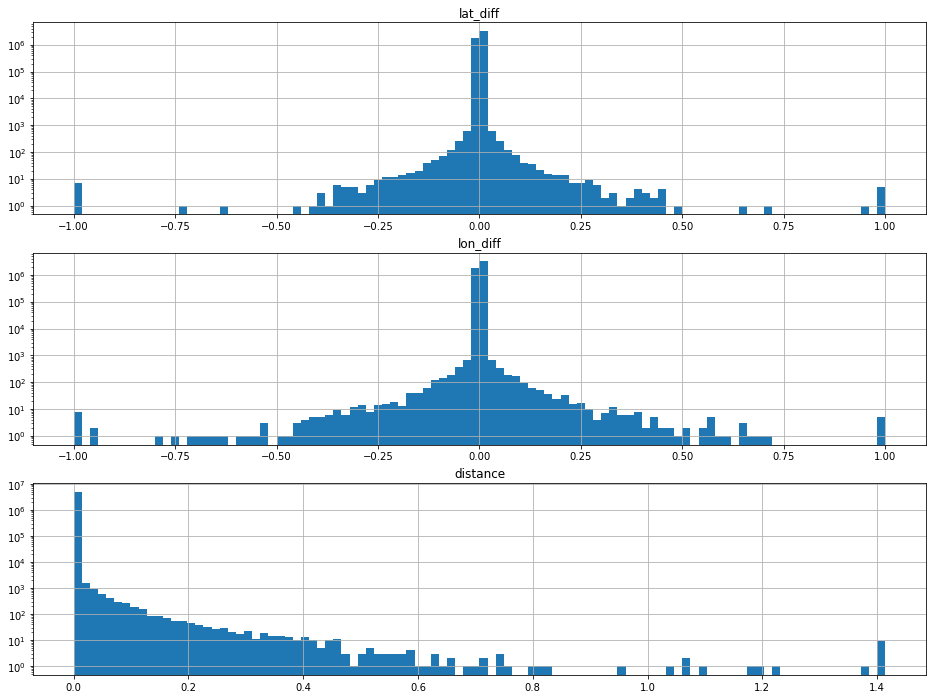

In [9]:
plt.figure(figsize=(16,12))

plt.subplot(311)
df_gps["lat_diff"].hist(bins=100)
plt.yscale("log")
plt.title("lat_diff")

plt.subplot(312)
df_gps["lon_diff"].hist(bins=100)
plt.yscale("log")
plt.title("lon_diff")

plt.subplot(313)
df_gps["dist"].hist(bins=100)
plt.yscale("log")
plt.title("distance")

plt.show()

In [69]:
def map_driver_routs(driver_hash, df=df_gps, min_points=10):
    driver_gps = df_gps[df_gps["driver_hash"] == driver_hash]
    center = (driver_gps["lat"].mean(), driver_gps["lon"].mean())
    m = folium.Map(location=center, zoom_start=10, legend=True)
    
    idx_column = "route_by_dist"
    route_ids = driver_gps[idx_column].unique()
    cmap = list(colors.XKCD_COLORS.values())
    legend = '<span style="color: {col};">by_dist_{txt}_({num})</span>'
    
    for i, idx in enumerate(route_ids):
        route_gps = driver_gps[driver_gps[idx_column] == idx]
        if route_gps.shape[0] < min_points:
            continue
            
        color = cmap[np.random.choice(len(cmap))]
        name = legend.format(txt=idx, col=color, num=route_gps.shape[0])
        fg = folium.FeatureGroup(name).add_to(m)
        folium.PolyLine(route_gps[["lat", "lon"]], color=color, weight=8, opacity=0.8).add_to(fg)

    idx_column = "route_by_time"
    route_ids = driver_gps[idx_column].unique()
    cmap = list(colors.XKCD_COLORS.values())
    legend = '<span style="color: {col};">by_time_{txt}_({num})</span>'
    
    for i, idx in enumerate(route_ids):
        route_gps = driver_gps[driver_gps[idx_column] == idx]
        if route_gps.shape[0] < min_points:
            continue
            
        color = cmap[np.random.choice(len(cmap))]
        name = legend.format(txt=idx, col=color, num=route_gps.shape[0])
        fg = folium.FeatureGroup(name).add_to(m)
        folium.PolyLine(route_gps[["lat", "lon"]], color=color, weight=6, opacity=0.8).add_to(fg)

        
    folium.map.LayerControl('topleft', collapsed= False).add_to(m)
    return m

In [73]:
# [1, 0, -1, None]
FORCE_FRAUD = None

if not FORCE_FRAUD is None:
    cur_driver = np.random.choice(df_gps.loc[df_gps["fraud"] == FORCE_FRAUD, "driver_hash"].unique())
else:
    cur_driver = np.random.choice(df_gps["driver_hash"].unique())

# пример водителя в большим количесвтом сматченных точек
# cur_driver = -6646726793274239750

fraud = df_gps.loc[df_gps["driver_hash"] == cur_driver,"fraud"].values[0]
display(f"Current Driver: {cur_driver} [fraud={fraud}]")

'Current Driver: -7649250495373212144 [fraud=-1]'

In [75]:
df_gps["route_by_dist"] = df_gps["dist"].round(2).cumsum().multiply(10).astype(int)
num_routes = len(df_gps["route_by_dist"].unique())
display(f"Number of routes by dist: {num_routes}")

df_gps["route_by_time"] = df_gps["gps_time_diff"].dt.round("120s").cumsum().dt.seconds
num_routes = len(df_gps["route_by_time"].unique())
display(f"Number of routes by time: {num_routes}")

map_driver_routs(cur_driver)

'Number of routes by dist: 3109'

'Number of routes by time: 720'